# In the first part of the code i will load the library DPU and the model.

We are loading the model through the DpuOverlay library

In [1]:
from pynq.lib.video import *
from pynq_dpu import DpuOverlay
overlay = DpuOverlay("dpu.bit")
overlay.load_model("dpu_face_binary_classifier_0.elf")

# Load libraries

In [11]:
from time import time
import numpy as np
from dnndk import n2cube
import matplotlib.pyplot as plt

# Setting the input and output layers.

In [12]:
KERNEL_NAME = "face_binary_classifier_0"
KERNEL_CONV_INPUT = "conv2d_1_convolution"
KERNEL_FC_OUTPUT = "output_logits_MatMul"

In [13]:
n2cube.dpuOpen()
kernel = n2cube.dpuLoadKernel(KERNEL_NAME)
task = n2cube.dpuCreateTask(kernel, 0)

In [14]:
input_len = n2cube.dpuGetInputTensorSize(task, KERNEL_CONV_INPUT)
size = n2cube.dpuGetOutputTensorSize(task, KERNEL_FC_OUTPUT)
channel = n2cube.dpuGetOutputTensorChannel(task, KERNEL_FC_OUTPUT)
conf = n2cube.dpuGetOutputTensorAddress(task, KERNEL_FC_OUTPUT)
outputScale = n2cube.dpuGetOutputTensorScale(task, KERNEL_FC_OUTPUT)

# Setting the camera as HW input.

In [15]:
# initialize camera from OpenCV
import cv2

videoIn = cv2.VideoCapture(0)
    
while(str(videoIn.isOpened())=="False"):
    videoIn = cv2.VideoCapture(0)
print("Capture device is open")

Capture device is open


# Testing the input image

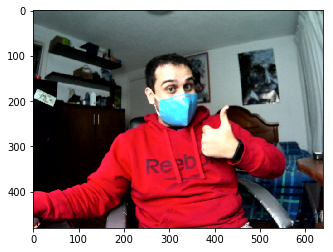

In [16]:
# Capture webcam image
import numpy as np

ret, frame = videoIn.read()
# Output webcam image as JPEG
%matplotlib inline 
from matplotlib import pyplot as plt
plt.imshow(frame[:,:,[2,1,0]])
plt.show()


# Testing the model, this code is in an infinite loop to stop it please stop the kernel.

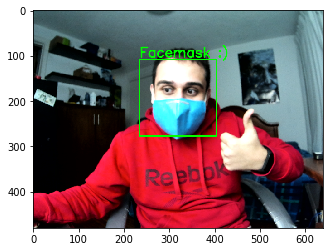

FPS:  393.64655091506336


In [ ]:
%matplotlib inline
import time
import pylab as plt
from IPython import display
%matplotlib inline 
from matplotlib import pyplot as plt

face_cascade = cv2.CascadeClassifier(
        '/home/xilinx/jupyter_notebooks/base/video/data/'
        'haarcascade_frontalface_default.xml')

while 1:
    ret, frame = videoIn.read()
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray, 1.3, 5)
    for (x,y,w,h) in faces:
        start_time = time.time()
        raw_data = []
        roi_gray = gray[y:y+h, x:x+w]
        roi_gray = cv2.resize(roi_gray, (64,64), interpolation = cv2.INTER_AREA)
        roi_gray = roi_gray/255.0
        raw_data.append(roi_gray)
        raw_data = np.array(raw_data, dtype="float32")
        raw_data = np.expand_dims(raw_data, axis=3)
        n2cube.dpuSetInputTensorInHWCFP32(task, KERNEL_CONV_INPUT, 
                                          raw_data[0,:,:,0], input_len)
        n2cube.dpuRunTask(task)
        softmax = n2cube.dpuRunSoftmax(conf, channel, size//channel, outputScale)
        prediction = softmax.argmax()
        print("FPS: ", 1.0 / (time.time() - start_time))
        if(prediction):
            frame = cv2.putText(frame, str("Facemask :)"), (x,y-5),cv2.FONT_HERSHEY_SIMPLEX, 1, (0,255,0), 2, cv2.LINE_AA)
            cv2.rectangle(frame,(x,y),(x+w,y+h),(0,255,0),2)
        else:
            frame = cv2.putText(frame, str("Facemask X"), (x,y-5),cv2.FONT_HERSHEY_SIMPLEX, 1, (0,0,255), 2, cv2.LINE_AA)
            cv2.rectangle(frame,(x,y),(x+w,y+h),(0,0,255),2)

    plt.imshow(frame[:,:,[2,1,0]])
    display.clear_output(wait=True)
    plt.show()
        
    

# Destroy DPU Kernel

In [9]:
n2cube.dpuDestroyKernel(kernel)
n2cube.dpuDestroyTask(task)

0